# Machine Learning Engineer Nanodegree

## Capstone Proposal
Marcos Wada  
July 27th, 2020

## Proposal

### Bitcoin
Bitcoin is a decentralized digital currency without a central bank or single administrator that can be sent from user to user on the peer-to-peer bitcoin network without the need for intermediaries.
Transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. Bitcoin was invented in 2008 by an unknown person or group of people using the name Satoshi Nakamoto and started in 2009 when its source code was released as open-source software. Bitcoins are created as a reward for a process known as mining. They can be exchanged for other currencies, products, and services.

### Bitcoin Price Forecasting
The goal of this project is to create a model that forecast bitcoin time series, predicting a sequence of prices that will happen at specific times using deep learning approaches.
I'll use dataset from two bitcoin exchanges for the time period of Jan 2012 to April 2020, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. (https://www.kaggle.com/mczielinski/bitcoin-historical-data)

### Implementation
I'll try to implement Long short-term memory (LSTM) network, an artificial recurrent neural network (RNN) architecture used in the field of deep learning. 
After developing the model, I'll benchmark performance with DeepAR, a built-in time series forecasting method based on RNN provided by Sagemaker.

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

# Load and Explore the Data

We'll be loading in some data about bitcoin pricing in the last few years.

In [252]:
csv_file = 'data/bitstamp.csv'
df = pd.read_csv(csv_file)

# print out the first few rows of data info
df.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4363452,1587513360,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790
4363453,1587513420,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449
4363454,1587513480,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966
4363455,1587513540,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090
4363456,1587513600,6850.60,6850.60,6850.60,6850.60,0.014436,98.896906,6850.600000


In [253]:
# Data size
df.shape

(4363457, 8)

In [254]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4363457 entries, 0 to 4363456
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 266.3 MB


In [255]:
# Null data
df.isnull().sum()

Timestamp                  0
Open                 1236977
High                 1236977
Low                  1236977
Close                1236977
Volume_(BTC)         1236977
Volume_(Currency)    1236977
Weighted_Price       1236977
dtype: int64

### Grouping daily data

We'll group this data with daily series.

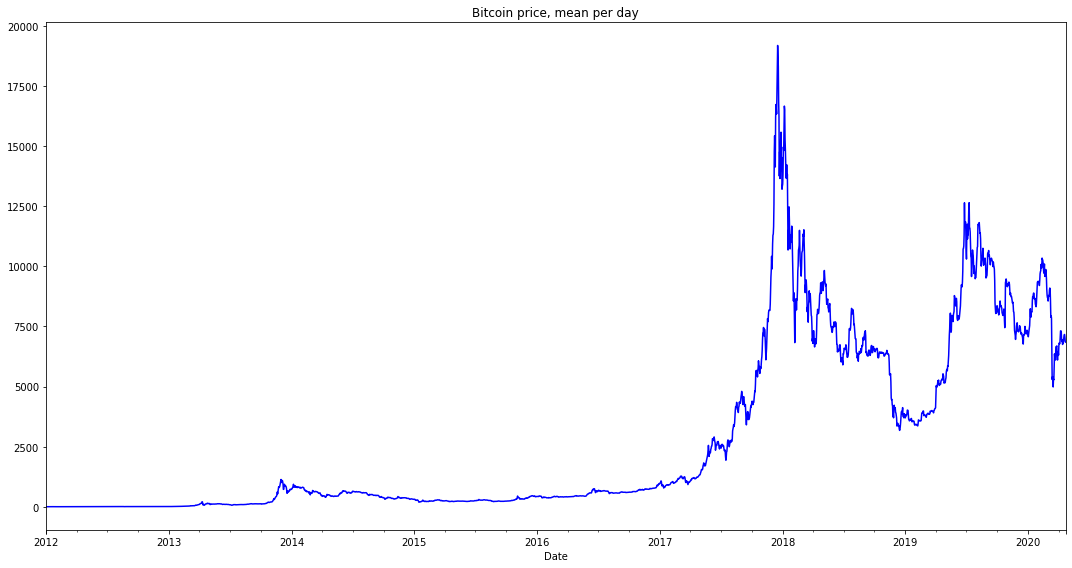

In [256]:
df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('Date')
mean_price_df = group['Weighted_Price'].mean()
mean_price_df.sort_index(inplace=True)
mean_price_df=mean_price_df.asfreq('D')
mean_price_df.fillna(method='ffill', inplace=True)

# display the mean values
plt.figure(figsize=(15,8))
mean_price_df.plot(title='Bitcoin price, mean per day', color='blue') 
plt.tight_layout()
plt.show()

## LSTM

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

### Preparing training set

In [257]:
prediction_days = 30
df_train = mean_price_df[:len(mean_price_df)-prediction_days]
df_test = mean_price_df[len(mean_price_df)-prediction_days:]

sc = MinMaxScaler()
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

We are going to use Keras to build the RNN LSTM

In [258]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:426: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.02). Is this intended?
  force_init=force_init)


 - 0s - loss: 0.0826
Epoch 2/100
 - 0s - loss: 0.0653
Epoch 3/100
 - 0s - loss: 0.0561
Epoch 4/100
 - 0s - loss: 0.0493
Epoch 5/100
 - 0s - loss: 0.0451
Epoch 6/100
 - 0s - loss: 0.0398
Epoch 7/100
 - 0s - loss: 0.0356
Epoch 8/100
 - 0s - loss: 0.0315
Epoch 9/100
 - 0s - loss: 0.0277
Epoch 10/100
 - 0s - loss: 0.0254
Epoch 11/100
 - 0s - loss: 0.0234
Epoch 12/100
 - 0s - loss: 0.0209
Epoch 13/100
 - 0s - loss: 0.0205
Epoch 14/100
 - 0s - loss: 0.0185
Epoch 15/100
 - 0s - loss: 0.0160
Epoch 16/100
 - 0s - loss: 0.0148
Epoch 17/100
 - 0s - loss: 0.0144
Epoch 18/100
 - 0s - loss: 0.0129
Epoch 19/100
 - 0s - loss: 0.0122
Epoch 20/100
 - 0s - loss: 0.0123
Epoch 21/100
 - 0s - loss: 0.0105
Epoch 22/100
 - 0s - loss: 0.0104
Epoch 23/100
 - 0s - loss: 0.0096
Epoch 24/100
 - 0s - loss: 0.0093
Epoch 25/100
 - 0s - loss: 0.0090
Epoch 26/100
 - 0s - loss: 0.0079
Epoch 27/100
 - 0s - loss: 0.0078
Epoch 28/100
 - 0s - loss: 0.0076
Epoch 29/100
 - 0s - loss: 0.0075
Epoch 30/100
 - 0s - loss: 0.0070
E

In [259]:
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

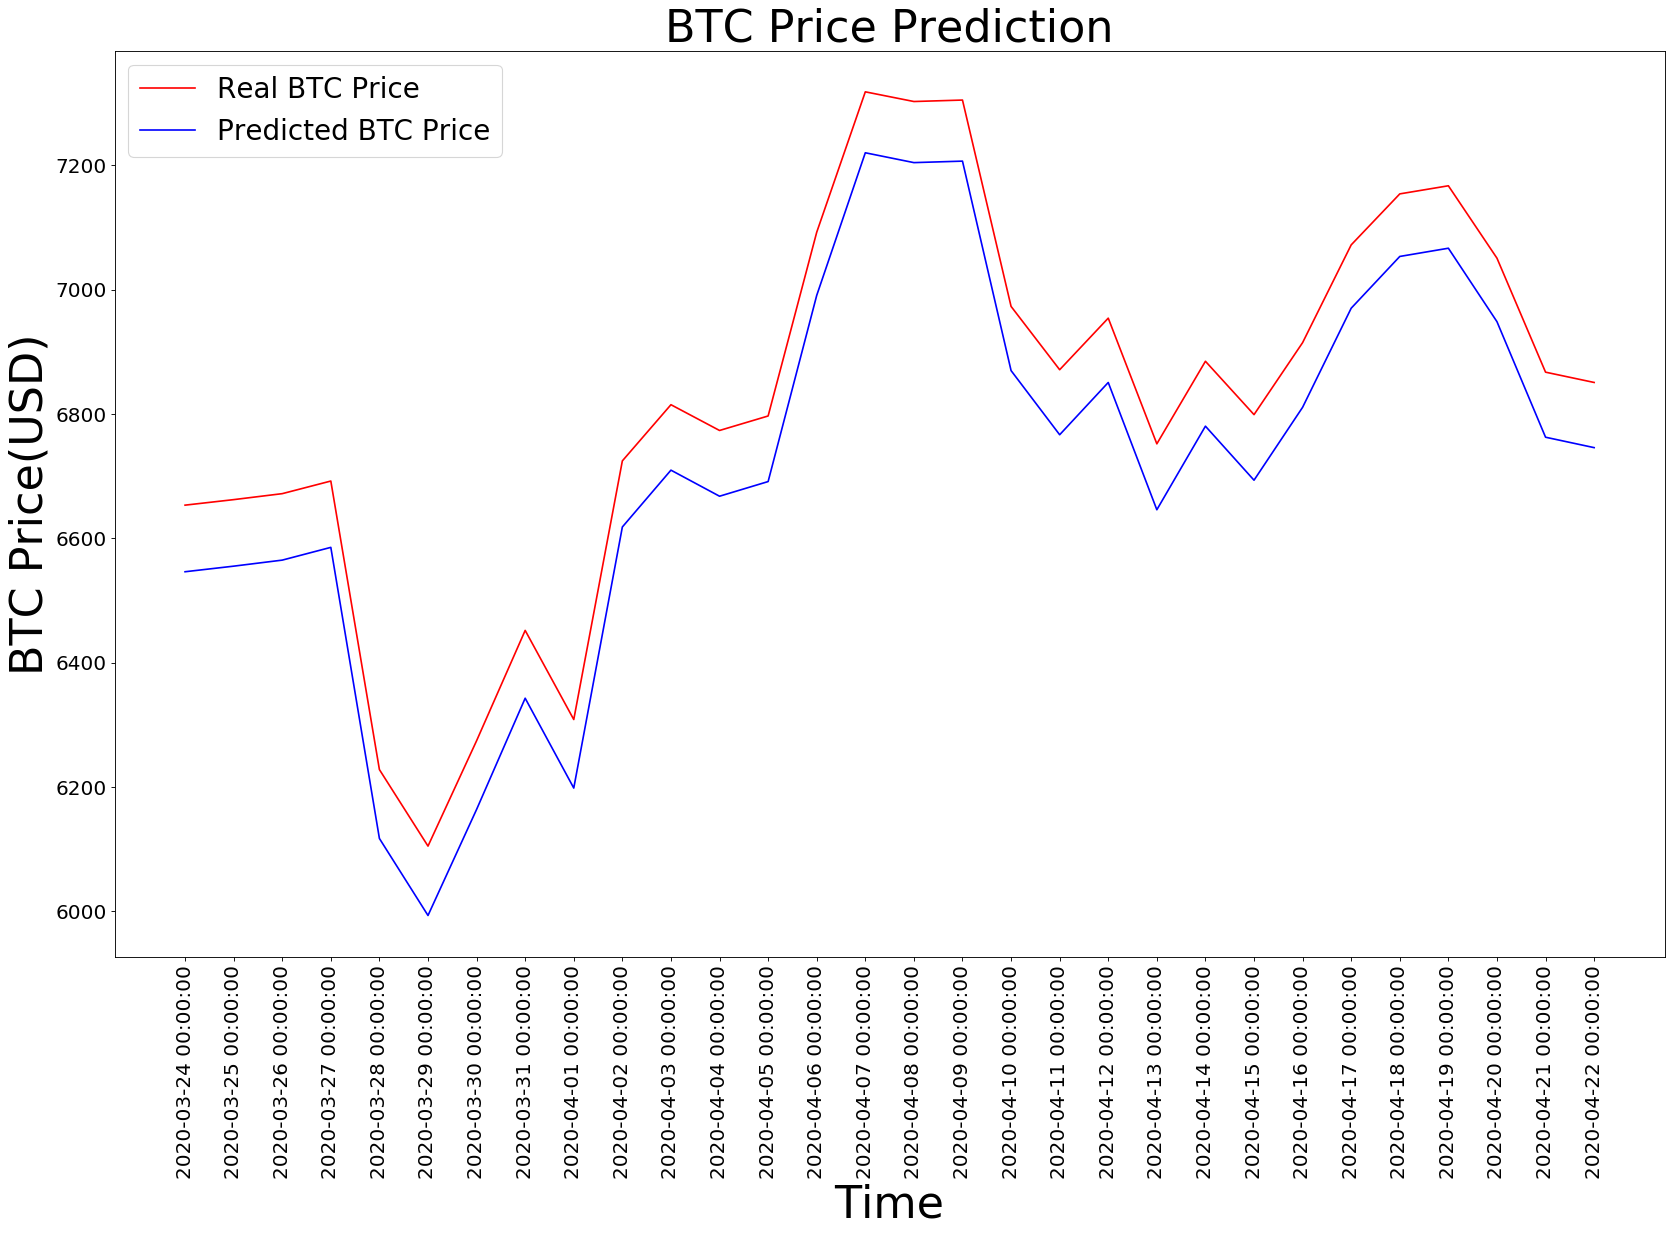

In [260]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['Date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

## DeepAR

DeepAR utilizes a recurrent neural network (RNN), which is designed to accept some sequence of data points as historical input and produce a predicted sequence of points.

> Since DeepAR trains on several time series, it is well suited for data that exhibit **recurring patterns**.

In any forecasting task, you should choose the context window to provide enough, **relevant** information to a model so that it can produce accurate predictions. In general, data closest to the prediction time frame will contain the information that is most influential in defining that prediction. In many forecasting applications, like forecasting sales month-to-month, the context and prediction windows will be the same size, but sometimes it will be useful to have a larger context window to notice longer-term patterns in data.

---
## Create Time Series 

My goal will be to take full years of data, from 2012-2019, and see if I can use it to accurately predict the average bitcoin price for the next several months in 2020.


The function `make_time_series` will create pandas `Series` for each of the passed in list of years `['2012', '2013', '2014','2015','2016','2017', '2018', ''2019']`.

```
# get bitcoin data
data = mean_price_df[start_idx:end_idx]

# create time series for the year
index = pd.DatetimeIndex(start=t_start, end=t_end, freq='D')
time_series.append(pd.Series(data=data, index=index))
```

In [261]:
def make_time_series(mean_price_df, years, freq='D', start_idx=1):
    '''Creates as many time series as there are complete years. This code
       accounts for the leap years, '2008', '2012', '2016', '2020'.
      :param mean_price_df: A dataframe of bitcoind prices, averaged by day.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2007', '2008'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 1, points to '2012-01-01'. 
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # store leap year in this dataset
    leap = ['2008', '2012', '2016', '2020']

    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        if(year in leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365
            

        # create start and end datetimes
        t_start = year + '-01-01' # Jan 1st of each year = t_start
        t_end = year + '-12-31' # Dec 31st = t_end

        # get global consumption data
        data = mean_price_df[start_idx:end_idx]
        # create time series for the year
        index = pd.date_range(start=t_start, end=t_end, freq=freq)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # return list of time series
    return time_series
    

## Test the results

Below, let's construct one time series for each complete year of data, and display the results.

In [262]:
# test out the code above

# yearly time series for our three complete years
full_years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
freq='D' # daily recordings

# make time series
time_series = make_time_series(mean_price_df, full_years, freq=freq)

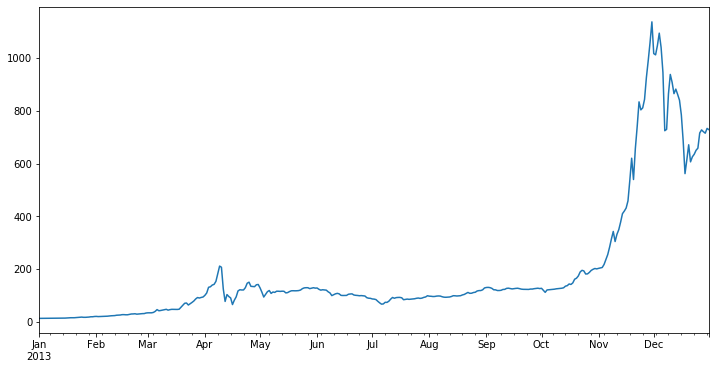

In [263]:
# display first time series
time_series_idx = 1

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

---
# Splitting in Time

We'll evaluate our model on a test set of data. For machine learning tasks like classification, we typically create train/test data by randomly splitting examples into different sets. For forecasting it's important to do this train/test split in **time** rather than by individual data points. 
> In general, we can create training data by taking each of our *complete* time series and leaving off the last `prediction_length` data points to create *training* time series. 

### EXERCISE: Create training time series

Complete the `create_training_series` function, which should take in our list of complete time series data and return a list of truncated, training time series.

* In this example, we want to predict about a month's worth of data, and we'll set `prediction_length` to 30 (days).
* To create a training set of data, we'll leave out the last 30 points of *each* of the time series we just generated, so we'll use only the first part as training data. 
* The **test set contains the complete range** of each time series.


In [264]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        # truncate trailing 30 pts
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training
    

In [265]:
# set prediction length
prediction_length = 30 # 30 days ~ a month

time_series_training = create_training_series(time_series, prediction_length)

### Training and Test Series

We can visualize what these series look like, by plotting the train/test series on the same axis. We should see that the test series contains all of our data in a year, and a training series contains all but the last `prediction_length` points.

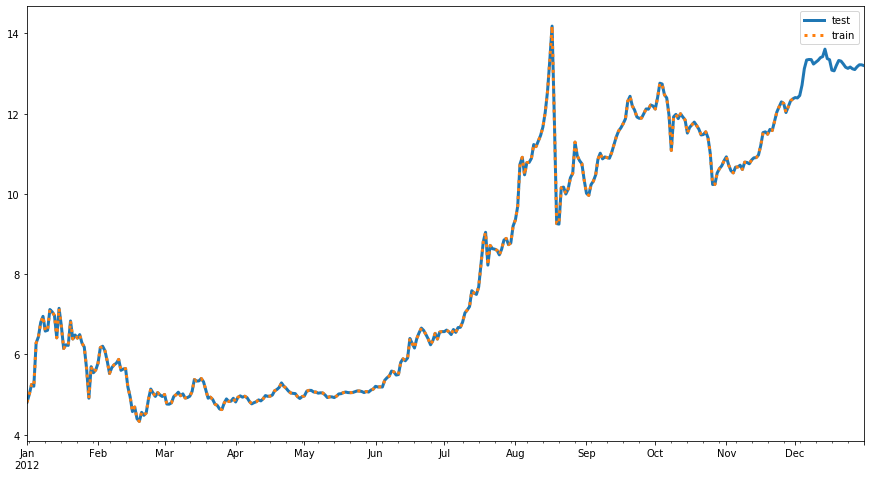

In [266]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON 

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```

In [267]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [268]:
# test out the code
ts = time_series[0]

json_obj = series_to_json_obj(ts)

### Saving Data, Locally

The next helper function will write one series to a single JSON line, using the new line character '\n'. The data is also encoded and written to a filename that we specify.

In [269]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [270]:
# save this data to a local directory
data_dir = 'price_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [271]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

price_data/train.json saved.
price_data/test.json saved.


---
## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.

### Sagemaker resources

Let's start by specifying:
* The sagemaker role and session for training a model.
* A default S3 bucket where we can save our training, test, and model data.

In [272]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [273]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()


### EXERCISE: Upoad *both* training and test JSON files to S3

Specify *unique* train and test prefixes that define the location of that data in S3.
* Upload training data to a location in S3, and save that location to `train_path`
* Upload test data to a location in S3, and save that location to `test_path`

In [274]:
# general prefix
prefix='deepar-bitcoin-forecasting'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [275]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-889637789333/deepar-bitcoin-forecasting/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-889637789333/deepar-bitcoin-forecasting/test/test.json


---
# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [276]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


### EXERCISE: Instantiate an Estimator 

You can now define the estimator that will launch the training job. A generic Estimator will be defined by the usual constructor arguments and an `image_name`. 
> You can take a look at the [estimator source code](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/estimator.py#L595) to view specifics.


In [277]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

Next, we need to define some DeepAR hyperparameters that define the model size and training behavior. Values for the epochs, frequency, prediction length, and context length are required.

* **epochs**: The maximum number of times to pass over the data when training.
* **time_freq**: The granularity of the time series in the dataset ('D' for daily).
* **prediction_length**: A string; the number of time steps (based off the unit of frequency) that the model is trained to predict. 
* **context_length**: The number of time points that the model gets to see *before* making a prediction. 

### Context Length

Typically, it is recommended that you start with a `context_length`=`prediction_length`. This is because a DeepAR model also receives "lagged" inputs from the target time series, which allow the model to capture long-term dependencies. For example, a daily time series can have yearly seasonality and DeepAR automatically includes a lag of one year. So, the context length can be shorter than a year, and the model will still be able to capture this seasonality. 

### Optional Hyperparameters

You can also configure optional hyperparameters to further tune your model. These include parameters like the number of layers in our RNN model, the number of cells per layer, the likelihood function, and the training options, such as batch size and learning rate. 

For an exhaustive list of all the different DeepAR hyperparameters you can refer to the DeepAR [hyperparameter documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [278]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [279]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training Job

Now, we are ready to launch the training job! SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the *actual* value of the time series. The computed error metrics will be included as part of the log output.

The next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [280]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-07-27 03:55:30 Starting - Starting the training job...
2020-07-27 03:55:32 Starting - Launching requested ML instances.........
2020-07-27 03:57:16 Starting - Preparing the instances for training......
2020-07-27 03:58:23 Downloading - Downloading input data...
2020-07-27 03:58:59 Training - Training image download completed. Training in progress..Arguments: train
[07/27/2020 03:59:02 INFO 139868515329856] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patienc

## Deploy and Create a Predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

In [281]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

---------------!CPU times: user 281 ms, sys: 12.8 ms, total: 294 ms
Wall time: 7min 33s


---
# Generating Predictions

According to the [inference format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) for DeepAR, the `predictor` expects to see input data in a JSON format, with the following keys:
* **instances**: A list of JSON-formatted time series that should be forecast by the model.
* **configuration** (optional): A dictionary of configuration information for the type of response desired by the request.

Within configuration the following keys can be configured:
* **num_samples**: An integer specifying the number of samples that the model generates when making a probabilistic prediction.
* **output_types**: A list specifying the type of response. We'll ask for **quantiles**, which look at the list of num_samples generated by the model, and generate [quantile estimates](https://en.wikipedia.org/wiki/Quantile) for each time point based on these values.
* **quantiles**: A list that specified which quantiles estimates are generated and returned in the response.


Below is an example of what a JSON query to a DeepAR model endpoint might look like.

```
{
 "instances": [
  { "start": "2009-11-01 00:00:00", "target": [4.0, 10.0, 50.0, 100.0, 113.0] },
  { "start": "1999-01-30", "target": [2.0, 1.0] }
 ],
 "configuration": {
  "num_samples": 50,
  "output_types": ["quantiles"],
  "quantiles": ["0.5", "0.9"]
 }
}
```


## JSON Prediction Request

The code below accepts a **list** of time series as input and some configuration parameters. It then formats that series into a JSON instance and converts the input into an appropriately formatted JSON_input.

In [282]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

### Get a Prediction

We can then use this function to get a prediction for a formatted time series!

In the next cell, I'm getting an input time series and known target, and passing the formatted input into the predictor endpoint to get a resultant prediction.

In [283]:
# get all input and target (test) time series
input_ts = time_series_training
target_ts = time_series

# get formatted input time series
json_input_ts = json_predictor_input(input_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)

print(json_prediction)

b'{"predictions":[{"quantiles":{"0.1":[11.6876783371,11.8829259872,11.5886974335,11.7113933563,11.6399240494,11.8225212097,11.8494672775,11.6577224731,11.630522728,11.7358083725,11.6053524017,11.6404466629,11.6800937653,11.1703233719,11.164896965,11.3595132828,11.4308519363,11.4289693832,11.3577022552,11.3926677704,11.262216568,11.0899791718,11.1745319366,11.0353183746,11.2314653397,11.1040363312,11.1775150299,10.8986644745,10.9842758179,11.1378097534],"0.9":[12.9575805664,12.8850488663,12.7594470978,13.0529661179,13.0635385513,13.0447568893,13.1941165924,13.1231946945,13.3012723923,13.2063083649,13.3258104324,13.2528953552,13.2401037216,13.2404975891,13.2672519684,13.3252620697,13.6353654861,13.3362445831,13.6200113297,13.4307174683,13.7519788742,13.3613538742,13.3660860062,13.2498054504,13.7915296555,13.386964798,13.048913002,13.4388055801,13.3422641754,13.4081335068],"0.5":[12.2267112732,12.2262992859,12.2519187927,12.4006385803,12.3885250092,12.4220304489,12.386973381,12.3184480667

## Decoding Predictions

The predictor returns JSON-formatted prediction, and so we need to extract the predictions and quantile data that we want for visualizing the result. The function below, reads in a JSON-formatted prediction and produces a list of predictions in each quantile.

In [284]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list


In [285]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[0])

          0.1        0.9        0.5
0   11.687678  12.957581  12.226711
1   11.882926  12.885049  12.226299
2   11.588697  12.759447  12.251919
3   11.711393  13.052966  12.400639
4   11.639924  13.063539  12.388525
5   11.822521  13.044757  12.422030
6   11.849467  13.194117  12.386973
7   11.657722  13.123195  12.318448
8   11.630523  13.301272  12.493621
9   11.735808  13.206308  12.435134
10  11.605352  13.325810  12.437515
11  11.640447  13.252895  12.418264
12  11.680094  13.240104  12.399051
13  11.170323  13.240498  12.413774
14  11.164897  13.267252  12.287525
15  11.359513  13.325262  12.319915
16  11.430852  13.635365  12.148339
17  11.428969  13.336245  12.065479
18  11.357702  13.620011  12.355985
19  11.392668  13.430717  12.186567
20  11.262217  13.751979  12.221020
21  11.089979  13.361354  12.161209
22  11.174532  13.366086  12.027212
23  11.035318  13.249805  12.026271
24  11.231465  13.791530  11.990610
25  11.104036  13.386965  12.219357
26  11.177515  13.048913  12

## Display the Results!

The quantile data will give us all we need to see the results of our prediction.
* Quantiles 0.1 and 0.9 represent higher and lower bounds for the predicted values.
* Quantile 0.5 represents the median of all sample predictions.


In [286]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

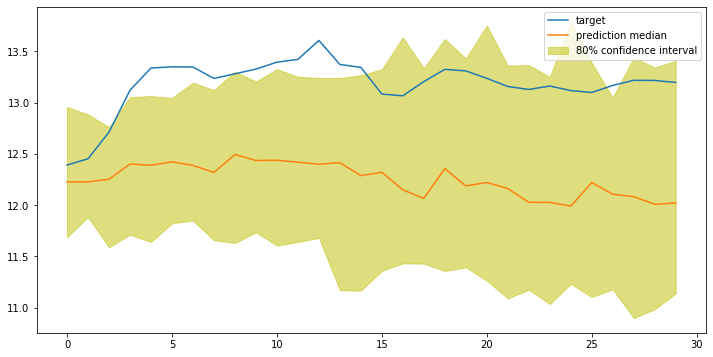

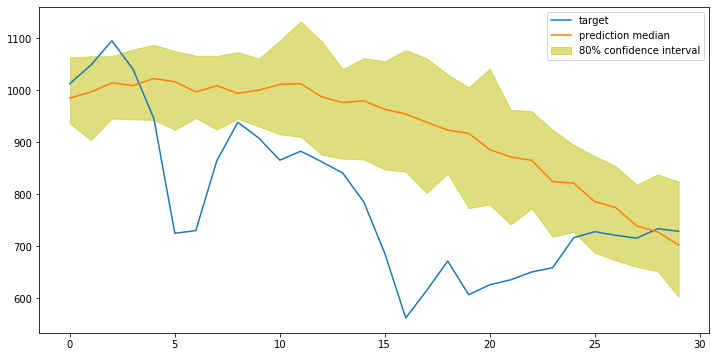

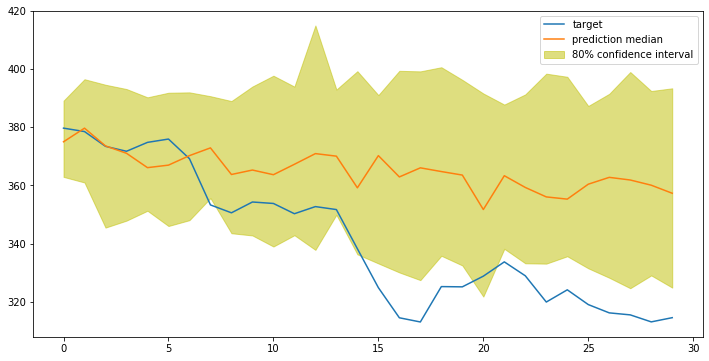

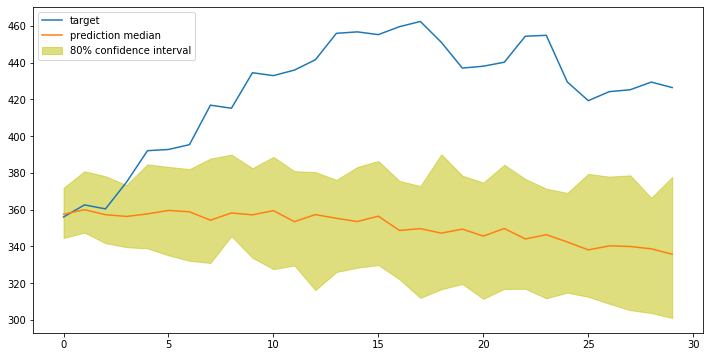

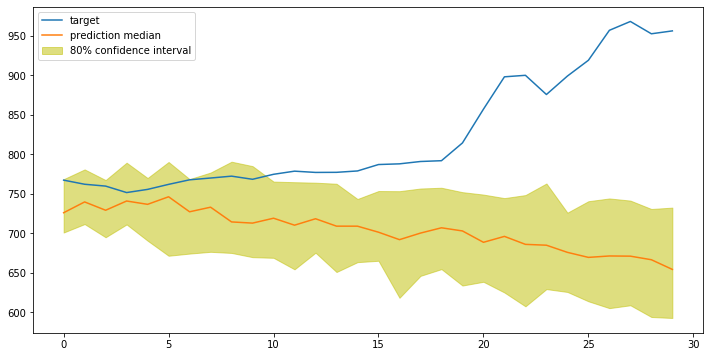

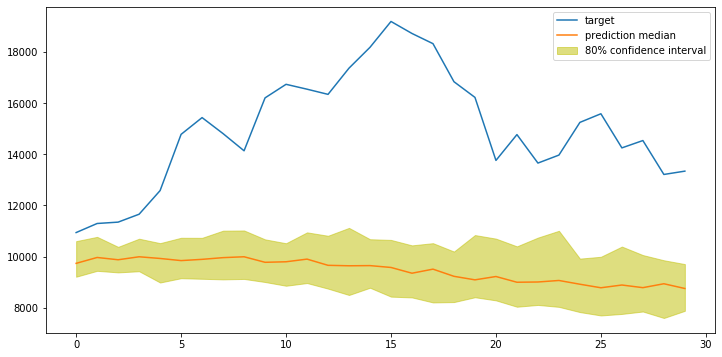

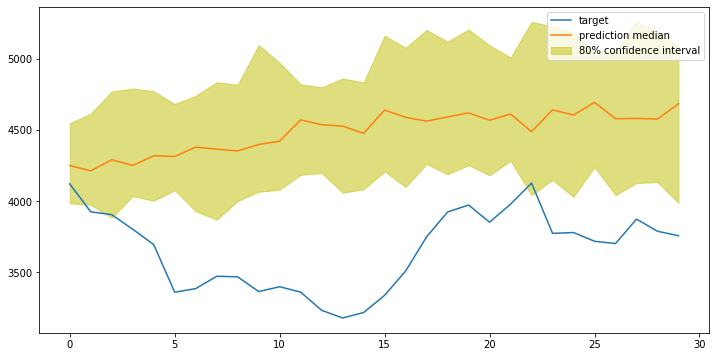

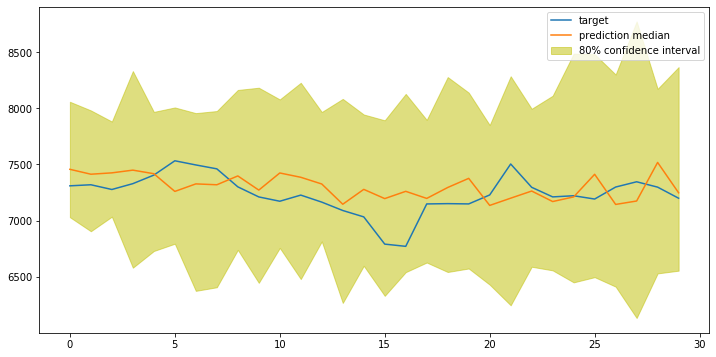

In [287]:
# display predictions
display_quantiles(prediction_list, target_ts)

## Predicting the Future

Recall that we did not give our model any data about 2010, but let's see if it can predict the energy consumption given **no target**, only a known start date!

### EXERCISE: Format a request for a "future" prediction

Create a formatted input to send to the deployed `predictor` passing in my usual parameters for "configuration". The "instances" will, in this case, just be one instance, defined by the following:
* **start**: The start time will be time stamp that you specify. To predict the first 30 days of 2010, start on Jan. 1st, '2010-01-01'.
* **target**: The target will be an empty list because this year has no, complete associated time series; we specifically withheld that information from our model, for testing purposes.
```
{"start": start_time, "target": []} # empty target
```

In [288]:
# Starting my prediction at the beginning of 2010
start_date = '2020-01-01'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": []}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2020-01-01 00:00:00


Then get and decode the prediction response, as usual.

In [289]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_2020 = decode_prediction(json_prediction)


Finally, I'll compare the predictions to a known target sequence. This target will come from a time series for the 2010 data, which I'm creating below.

In [290]:
# create 2020 time series
ts_2020 = []

# get global consumption data
# index 1112 is where the 2010 data starts
data_2020 = mean_price_df.values[2923:]

index = pd.date_range(start=start_date, periods=len(data_2020), freq='D')
ts_2020.append(pd.Series(data=data_2020, index=index))

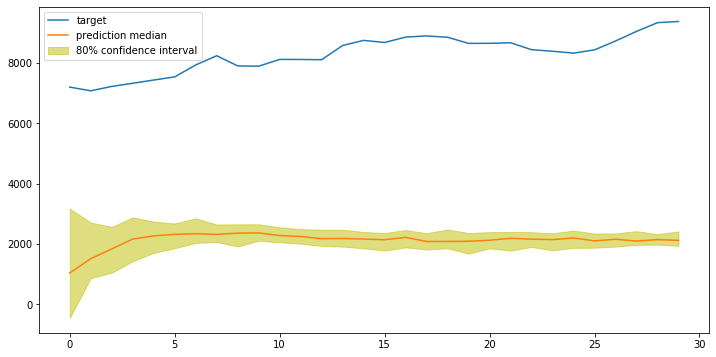

In [291]:
# range of actual data to compare
start_idx=0 # days since Jan 1st 2010
end_idx=start_idx+prediction_length

# get target data
target_2020_ts = [ts_2020[0][start_idx:end_idx]]

# display predictions
display_quantiles(prediction_2020, target_2020_ts)

In [292]:
predictor.delete_endpoint()